# Problem Set 5: Trees, Forests, and Networks


## Part 1: Exploring The Titanic

Your mission for this problem set is to use your knowledge of supervised machine learning to try to predict which passengers aboard the Titanic were most likely to survive. The prompts for this part of the problem set are deliberately vague - the goal is to leave it up to you how to structure (most of) your analysis. We **highly recommend** you closely go over the entire problem set once before starting; this is important, so that you understand the sequence of steps and not perform redundant work.

To get started, read about the prediction problem on [Kaggle](https://www.kaggle.com/c/titanic). Then, download the data [here](https://www.kaggle.com/c/titanic/data) - you'll need the `train.csv` data. Treat this as your entire dataset, and further build train and test splits from this dataset whenever required. 

### 1.1 Exploratory data analysis

Create at least 3 figures and/or tables that help give you a feel for the data. Make sure to at least check at least the following - 

1) the data type of each variable and variables that have missing observations 

2) understand the distribution of each variable (and determine whether the variables should be standardized or not)

3) are any of the potential predictor variables (i.e., anything execpt for survival) collinear or highly correlated? 

Remember that this is the EDA phase, and we want to save pre-processing steps like imputations, transformations etc. and feature engineering for later. Feel free to create more charts and tables if they help your analysis.

In [698]:
# Your code here
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, r2_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# from keras.models import Sequential
# from keras.layers import Dense

In [699]:
df = pd.read_csv('train.csv')
X = df.loc[:,df.keys()!='Survived']
y = df.loc[:, df.keys()=='Survived']

In [700]:
X

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
886,887,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [701]:
X.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200


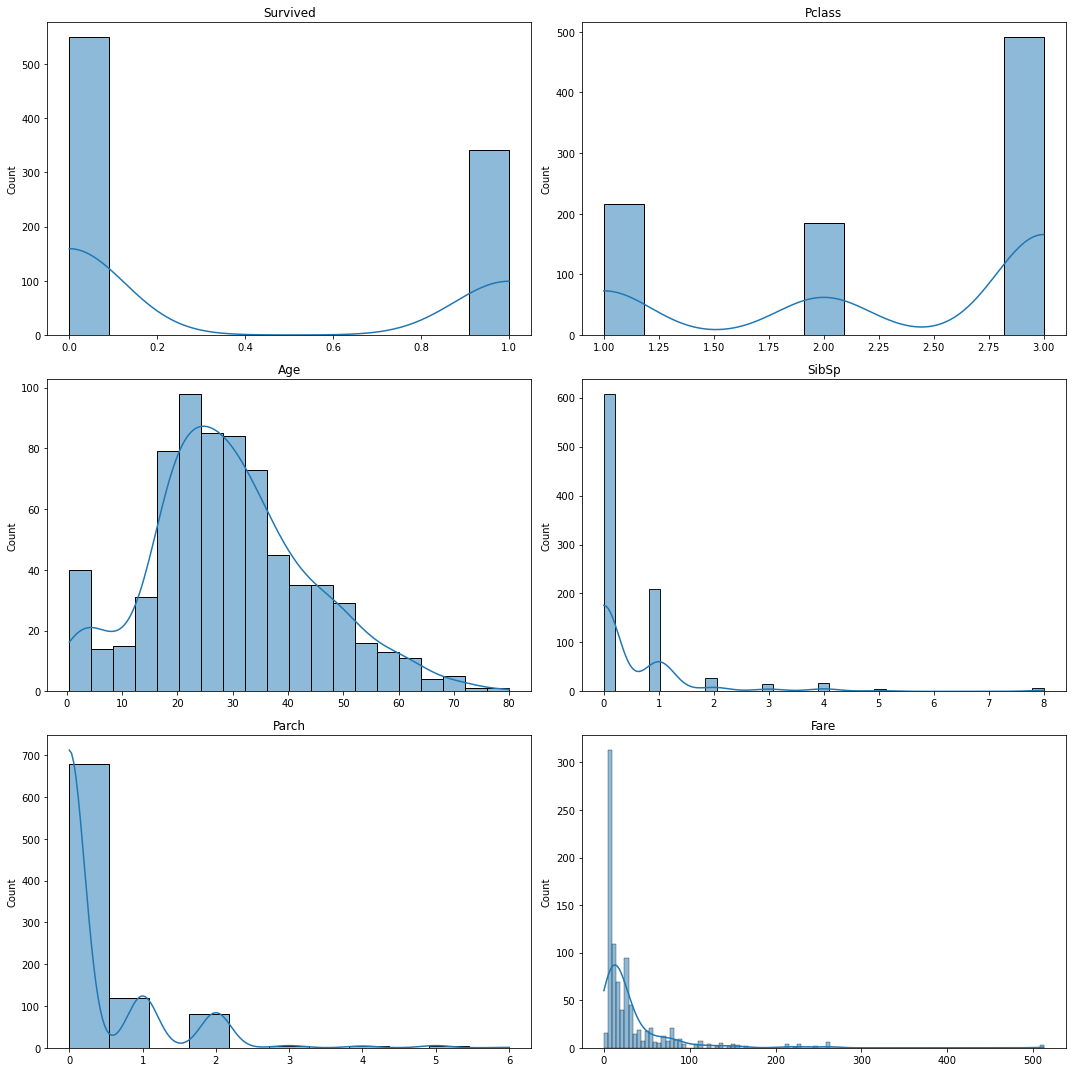

In [702]:
display_features = ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
fig, ax = plt.subplots(3,2)
fig.set_figheight(15)
fig.set_figwidth(15)
for i in range(3):
    for j in range(2):
        sns.histplot(df[display_features[(2*i)+j]], kde=True, ax=ax[i][j])
        ax[i][j].set_title(display_features[(2*i)+j])
        ax[i][j].set_xlabel('')

plt.tight_layout()
plt.show();

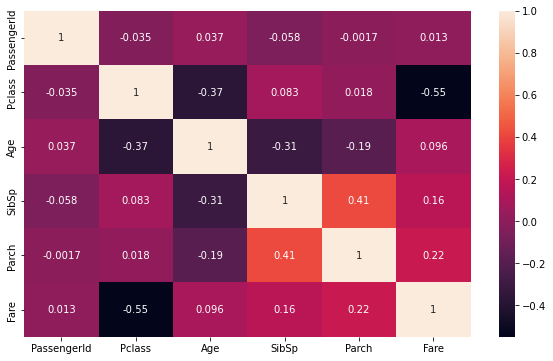

In [703]:
plt.figure(figsize=(10,6))
sns.heatmap(X.corr(), annot=True);

*Your observations here*

* __Data Types:__
    * PassengerID: Integer
    * Survived: Binary Integer
    * Pclass: Trinary Integer
    * Name: Text
    * Sex: Text (Binary)
    * Age: Float - there are missing values
    * SibSp: Int
    * Parch: Int
    * Ticket: Text
    * Fare: Float
    * Cabin: Int - there are missing values
    * Embarked: Text - there are missing values (but only seem to be 2)

* __Missing Values:__
    * There are missing values in the variables Age, Cabin and Embarked (although there only seem to be 2 missing values for Embarked)

* __Distribution of Predictor Variables:__ Age and Fare have much higher standard deviations than the other variables, because their ranges are much bigger. For example the standard deviation of Fare is almost 50, while the standard deviations for Pclass, SibSp and Parch are all around 1. A lot of predictor variables are quite skewed - for instance, a lot of people had very low fares, while some people paid a large amount. Similarly, there were many people traveling alone (e.g. without parent or child).

* __Correlations:__ The highest correlations among potential predictor variables are Pclass and Fare (-0.55 correlation), Parch and SibSp (0.41), Pclass and Age (-0.37), and SibSp and Age(-0.31). The first makes sense becuase the lower your passenger class, the higher your fare (because 1st class is the highest class). The second and third make sense because it likely indicates family groups (e.g. if your parents are on board, your siblings likely are as well, and vice versa). Two more variables with some correlation between them are Parch and Fare (0.22) and Parch and Age (-0.19). These also reflect some information about family units - it appears that if your parent/child is onboard, your fare is higher, and if your parent is onboard, you are likely to be younger. I interpret this as showing that more affluent families are likely travelling as a unit on the Titanic.

### 1.2 Correlates of survival

Use whatever methods you can think of to try and figure out what factors seem to determine whether or not a person would survive the sinking of the Titanic. You can start with simple correlations, but will likely also want to use multiple regression and/or other methods in your toolkit. Try at least 3 different methods. What do you conclude?

##### Method 1: Simple Correlation

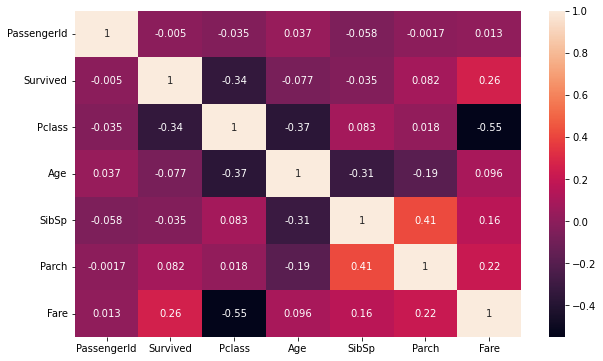

In [704]:
# Your code here
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True);

*The two variables that jump out the most from a simple correlation of the numerical features are Pclass and Fare. Fare is positively correlated with survival (corr=0.26), while Pclass is negatively correlated (corr=-0.34). This indicates that people in higher passenger classes (e.g. 1st class vs. 3rd class) were more likely to survive. Similarly, if you paid more for your fare, you were more likely to survive. It is likely that both of these variables are reflecting the same thing, as their joint correlation is pretty high (corr=-0.55). The next highest correlation is with Parch (corr=0.082), but the relationship is much less strong. Since we haven't done preprocessing, I'm most interested in some of the dummy variables, such as Embarked or information gleaned from your name (e.g. member of the clergy or some other position of importance).*

##### Method 2: Regression

In [705]:
model = smf.ols(formula='Survived ~ Pclass + Sex + Age + SibSp + Parch + Fare + Embarked', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               Survived   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     58.84
Date:                Mon, 03 Apr 2023   Prob (F-statistic):           2.73e-73
Time:                        12:23:27   Log-Likelihood:                -321.06
No. Observations:                 712   AIC:                             660.1
Df Residuals:                     703   BIC:                             701.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.4031      0.082     17.214

*Moving from simple correlations to multivariate linear regression produced some interesting results. Pclass still remained signficiant - moving from a higher class to a lower class is associated with an 18.74% decreased chance of survivial. However, Fare is not statistically signficiant (due to a very small coefficient). This may be because the exact difference in fares between one passenger to the next wasn't imporant in decision-making, and one's passenger class was more important. As we saw above, these variables were highly correlated.*

*I was able to add a few more variables in that we weren't able to evaluate with simple correlations. Specifically, it seems that one's sex was really important - men were 48.54% less likely to survive than women. Similarly, being older, or having lots of siblings on board decreased your chance of survivial. This may reflect younger people being put on lifeboats, rather than old, and it being easier to get on lifeboats by yourself than with a large family.*

##### Method 3: Logistic regression

In [706]:
features = ['Pclass', 'SibSp', 'Parch', 'Fare']
X = df.loc[:,features]
y = np.array(df.loc[:, df.keys()=='Survived']).ravel()
X = sm.add_constant(X)
log_reg = sm.Logit(y, X).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.599982
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  891
Model:                          Logit   Df Residuals:                      886
Method:                           MLE   Df Model:                            4
Date:                Mon, 03 Apr 2023   Pseudo R-squ.:                 0.09901
Time:                        12:23:27   Log-Likelihood:                -534.58
converged:                       True   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 1.838e-24
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9117      0.300      3.035      0.002       0.323       1.501
Pclass        -0.6953      0.

*For my third method, I used logistic regression to predict the probability of survival, and the relationship of some of the variables to survival. Since we haven't done any preprocessing, there are still many variables that I cannot use (e.g. all of the dummy variables and text variables). Using the features Pclass, SibSp, Parch, and Fare, the logistic model found an even greater negative relationship between going up a class and reduced chance of survival. Similarly, the results indicate having multiple siblings on board also decreased your chance of survival (although p>0.05), but having a parent on board increased your chance of survival. Interestingly, compared to the multivariate linear regression, Fare is statistically signficant, albiet a small coefficient. This is likely because of large differences in cost between 1st class and 3rd class.*

### 1.3 Preprocessing steps
Take whatever pre-processing steps you believe are necessary for each variable in the dataset (for example, these might include normalization, standardization, log transforms, dummy-encoding, or dropping a variable altogether). For now, you can ignore null values in the dataset --- we'll come back to those later. __Create a table describing the preprocessing step for each variable.__ Make sure the variables are alphabetized and your table is well-organized.

In [707]:
# Creating table with all variables before I drop later on
preprocessing = df.T[[0,1,2,3]]

#### Creating passenger class dummies

In [708]:
pclass = pd.get_dummies(df['Pclass'])
pclass.columns = ['First_Class', 'Second_Class', 'Third_Class']
pclass
df = pd.concat([df, pclass], axis=1)

#### Creating title dummies

In [709]:
title = df['Name'].str.split(expand=True)[1].to_frame()
title.columns = ['Title']
title.value_counts()
titles = pd.get_dummies(title)
# Only selecting the top six highest count titles
titles = titles[['Title_Mr.', 'Title_Mrs.', 'Title_Miss.', 'Title_Master.', 'Title_Dr.', 'Title_Rev.']]
df = pd.concat([df, titles], axis=1)
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked,First_Class,Second_Class,Third_Class,Title_Mr.,Title_Mrs.,Title_Miss.,Title_Master.,Title_Dr.,Title_Rev.
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,S,0,0,1,1,0,0,0,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,...,C,1,0,0,0,1,0,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,S,0,0,1,0,0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,S,1,0,0,0,1,0,0,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,S,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,...,S,0,1,0,0,0,0,0,0,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,...,S,1,0,0,0,0,1,0,0,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,...,S,0,0,1,0,0,1,0,0,0
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,...,C,1,0,0,1,0,0,0,0,0


#### Creating gender dummies

In [710]:
gender = pd.get_dummies(df['Sex'])
df = pd.concat([df, gender], axis=1)
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Second_Class,Third_Class,Title_Mr.,Title_Mrs.,Title_Miss.,Title_Master.,Title_Dr.,Title_Rev.,female,male
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,1,1,0,0,0,0,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,...,0,0,0,1,0,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,1,0,0,1,0,0,0,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,0,0,1,0,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,1,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,...,1,0,0,0,0,0,0,1,0,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,...,0,0,0,0,1,0,0,0,1,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,...,0,1,0,0,1,0,0,0,1,0
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,...,0,0,1,0,0,0,0,0,0,1


#### Creating child variable

In [711]:
# Age
df['Child'] = (df['Age'] < 18.0).astype(int)

#### Creating family travel variable

In [712]:
# Indicates whether someone is traveling with more than one parent/child and more than one sibling/spouse
df['Family_Travel'] = ((df['Parch']>0) & (df['SibSp'] > 0)).astype(int)

#### Creating Family size variable

In [713]:
# Using unique ticket values to identify group sizes
df['Family_Size'] = df.groupby("Ticket")['Ticket'].transform('count')

#### Creating Traveling alone variable

In [714]:
# Similar to the variable above, but a dummy indicating whether someone is traveling alone
df['Traveling Alone'] = (df.groupby("Ticket")['Ticket'].transform('count')==1).astype(int)

#### Log Fare

In [715]:
# Adding 1 to all fares because some people are listed as having paid nothing and log(0) is -inf
df['Log_Fare'] = np.log(df['Fare']+1)

#### Cabin

In [716]:
# Note: Not creating cabin-based variables because of large number of null values

#### Creating Embarkation dummies

In [717]:
ports = pd.get_dummies(df['Embarked'])
ports.columns = ['Cherbourg', 'Queenstown', 'Southampton']
df = pd.concat([df, ports], axis=1)
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,female,male,Child,Family_Travel,Family_Size,Traveling Alone,Log_Fare,Cherbourg,Queenstown,Southampton
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,1,0,0,1,1,2.110213,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,...,1,0,0,0,1,1,4.280593,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,1,0,0,0,1,1,2.188856,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,1,0,0,0,2,0,3.990834,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,1,0,0,1,1,2.202765,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,...,0,1,0,0,1,1,2.639057,0,0,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,...,1,0,0,0,1,1,3.433987,0,0,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,...,1,0,0,1,2,0,3.196630,0,0,1
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,...,0,1,0,0,1,1,3.433987,1,0,0


#### Dropping variables

In [718]:
# Name, Cabin, Pclass, Sex, Ticket, Embarked
full_df = df.copy()
df = df.drop(['Name','Cabin', 'Pclass', 'Sex', 'Ticket', 'Embarked'], axis=1)

In [719]:
df.shape

(891, 25)

#### Creating preprocessing table

In [720]:
# Your code here
preprocessing.columns = ['Create dummy variables', 'Generate new variables', 'Log Transformation', 'Drop']

# Setting default values to 0 
preprocessing['Create dummy variables'] = 0
preprocessing['Generate new variables'] = 0
preprocessing['Log Transformation'] = 0
preprocessing['Drop'] = 0

# Indicating which variables were used to create dummies
preprocessing.loc[['Pclass', 'Name', 'Sex', 'Age', 'Parch', 'SibSp', 'Ticket', 'Embarked'], 'Create dummy variables'] = 1

# Indicating which variables were used to generate new variables
preprocessing.loc[['Age', 'Parch', 'SibSp', 'Ticket'], 'Generate new variables'] = 1


# Indicating which variables had log transformations
preprocessing.loc['Fare', 'Log Transformation'] = 1

# Indicating which variables have been dropped
preprocessing.loc[['Name','Cabin', 'Pclass', 'Sex', 'Ticket', 'Embarked'], 'Drop'] = 1

# Preprocessing table
preprocessing

,Create dummy variables,Generate new variables,Log Transformation,Drop
PassengerId,0,0,0,0
Survived,0,0,0,0
Pclass,1,0,0,1
Name,1,0,0,1
Sex,1,0,0,1
Age,1,1,0,0
SibSp,1,1,0,0
Parch,1,1,0,0
Ticket,1,1,0,1
Fare,0,0,1,0


In [721]:
# Creating arrays to store model performances for problem 5
cross_val_perf = np.zeros([8])
train_perf = np.zeros([8])
test_perf = np.zeros([8])
chosen_hyperparams = [{}, {}, {}, {}, {}, {}, {}, {}]

## Part 2: Decision Trees
### 2.1 Decision Tree
Using the basic [Decision Tree Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)  in sklearn, fit a model to predict titanic survival, using 10-fold cross-validation. For this and the following problems, you should set aside some (20%) of your training data as held-out test data, prior to cross-validation. 

Begin by using the default hyperparameters, and report the average training and cross-validated accuracy across the 10 folds.  Then, fit a single decision tree model on all of the training data (i.e., no cross-validation in this particular step), and report the performance of this fitted model on the held-out test data -- how does it compare to the cross-validated accuracy? Finally, show a diagram of this tree (at least the first three levels of splits), and provide a couple sentences interpreting the tree diagram.

NOTE - You may drop columns with null values for now; we'll come back to those columns later in the problem set.

In [722]:
# Your code here
clf = DecisionTreeClassifier(random_state=0)
features = ['SibSp', 'Parch', 'Fare',
       'First_Class', 'Second_Class', 'Third_Class', 'Title_Mr.', 'Title_Mrs.',
       'Title_Miss.', 'Title_Master.', 'Title_Dr.', 'Title_Rev.', 'female',
       'Child', 'Family_Travel', 'Family_Size', 'Traveling Alone',
       'Log_Fare', 'Cherbourg', 'Queenstown', 'Southampton']
X = df.loc[:,features]
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
average_cross_val_score = cross_val_score(clf, X_train, y_train, cv=10).sum() / 10
print("The average cross validated score is: {}".format(np.round(average_cross_val_score,3)))

The average cross validated score is: 0.803


Score on train data: 0.9382022471910112
Score on holdout test data: 0.7877094972067039


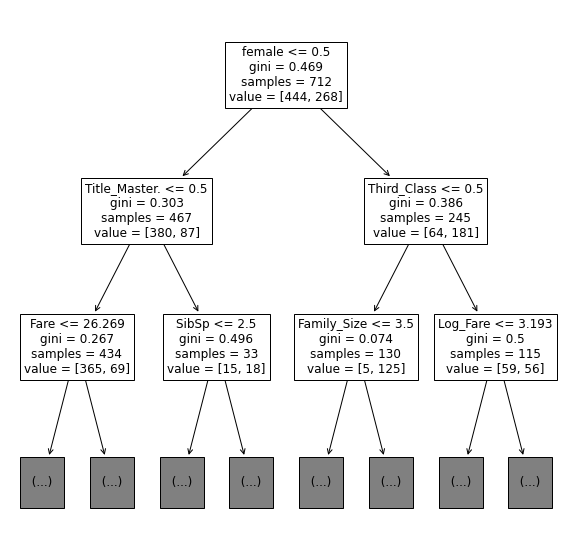

In [723]:
plt.figure(figsize=(10,10))
clf.fit(X_train, y_train)

print("Score on train data: {}".format(clf.score(X_train, y_train)))
print("Score on holdout test data: {}".format(clf.score(X_test, y_test)))
tree.plot_tree(clf, max_depth=2, fontsize=12, feature_names=X.columns)
plt.show();

*The cross-validated score is 0.806, while the score using the test data is 0.787.*

*The tree starts by splitting the data based on gender. That indicates that there is a substantial difference in survival rates among men and women. Then, for women, it splits on specifically whether or not that woman was in third class. Then, it splits on family size or fare, log fare, embarking from Southampton, SibSp, etc. For the men, it then splits on the title "Master." I was surprised to see this - I was interested in titles to see if Doctors and clergymembers were likely to survive, but there weren't many (the total n for those was like 13, and most of them died). I interpret this to be a proxy for wealth, but it's interesting that it didn't use fare or 1st class here. After this, it does split on fare and SibSp. I'm not sure why the title of Master was more predictive than those other factors related to wealth/status.*

### 2.2 Hyperparameter: Maximum Depth

Use all of the training data (minus the held-out test data) to re-fit a single decision tree with `max_depth = 4` (i.e., no cross-validation). Show the tree diagram and also plot the feature importance. What do you observe? How does the performance of this tree compare to the tree from 2.1?

Score on holdout test data: 0.8212290502793296


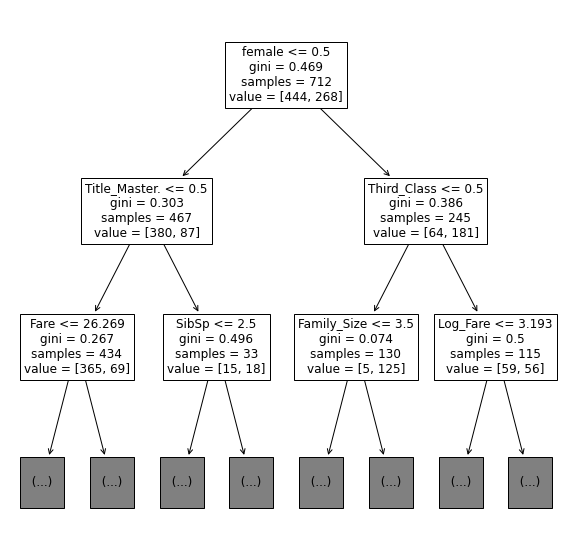

In [724]:
# Your code here
clf = DecisionTreeClassifier(max_depth=4, random_state=0)
X = df.loc[:,features]
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Saving original data for problem 5
y_train_original = y_train.copy()
X_train_original = X_train.copy()
y_test_original = y_test.copy()
X_test_original = X_test.copy()

# Fitting the model
clf.fit(X_train, y_train)
print("Score on holdout test data: {}".format(clf.score(X_test, y_test)))
plt.figure(figsize=(10,10))
tree.plot_tree(clf, max_depth=2, fontsize=12, feature_names=X.columns)
plt.show();

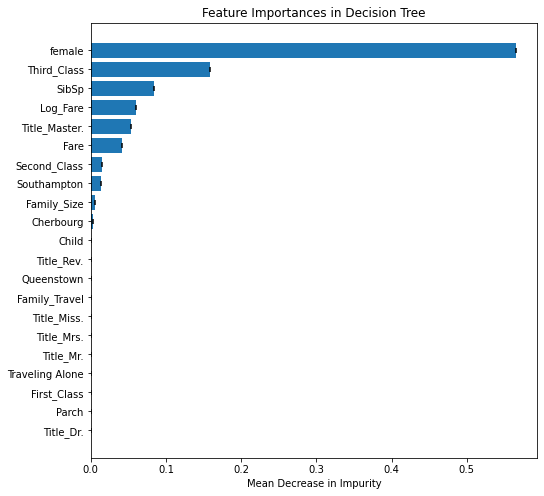

In [725]:
clf.feature_importances_
importances = pd.DataFrame([features, clf.feature_importances_]).T
importances.columns = ['Feature', 'Importance']
importances = importances.sort_values('Importance', ascending=True)
importances
std = np.std(clf.feature_importances_)
fig, ax = plt.subplots(1, figsize=(8, 8))
plt.barh(importances['Feature'], importances['Importance'], yerr=std)
ax.set_xlabel('Mean Decrease in Impurity')
ax.set_title('Feature Importances in Decision Tree')
plt.show()

*Changing the max depth hyperparameter to 4 improves the accuracy of the Deceision Tree from 0.787 to 0.821.*

*The tree itself didn't change much. Showing just the first two layers, the tree doesn't show any demonstrable changes. I assume that the changes that improve accuracy occur further down in the tree, which makes sense since we have adjusted the max depth we can achieve.*

*Looking at the feature importances, the decision tree mostly followed the order of importance. It started with gender every time, and split on third class for the women. However, for some reason, Title_Master ended up being the next more important on the male side. This shows how it is calculating importance at each step (e.g. it would have used SibSp next if it was just going down the overall importance list).*

### 2.3  Tuning Hyperparameters
The built-in algorithm you are using has several parameters which you can tune. Using cross-validation, show how the choice of these parameters affects performance.

First, show how `max_depth` affects train and cross-validated accuracy. On a single axis, plot train and cross-validated accuracy as a function of `max_depth`. Use a red line to show cross-validated accuracy and a blue line to show train accuracy. Do not use your held-out test data yet.

Second, show how cross-validated accuracy relates to both `max_depth` and `min_samples_leaf`. Specifically, create a 3-D plot where the x-axis is `max_depth`, the y-axis is `min_samples_leaf`, and the z-axis shows cross-validated accuracy. What combination of `max_depth` and `min-samples_leaf` achieves the highest accuracy? How sensitive are the results to these two parameters?

Finally, select the the best hyperparameters that you got through cross-validation, and fit a single decision tree on all of the training data using those hyperparameters. Display this tree and report the accuracy of this tree on the held-out data.

Best maximum depth: 8
Accuracy (train): 0.89
Accuracy (test): 0.82
Precision (train): 0.74
Precision (test): 0.69
Recall (train): 0.95
Recall (test): 0.84


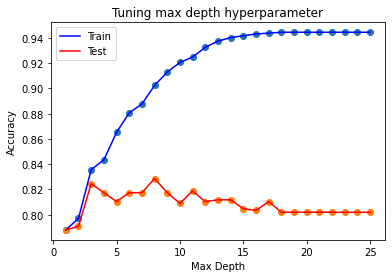

In [726]:
model = DecisionTreeClassifier(random_state=0)
cv = KFold(n_splits=3, shuffle=True, random_state=0)
params = {'max_depth':[i+1 for i in range(25)], \
         }
cv_model = GridSearchCV(model, param_grid=params, scoring='accuracy', refit=True, return_train_score=True, cv=cv)
cv_model.fit(X_train, y_train)
model = cv_model.best_estimator_
model.fit(X_train, y_train)
yhat_train = model.predict(X_train)
yhat_test = model.predict(X_test)

print('Best maximum depth: %i' % cv_model.best_params_['max_depth'])

print('Accuracy (train): %.2f' % accuracy_score(y_train, yhat_train))
print('Accuracy (test): %.2f' % accuracy_score(y_test, yhat_test))

print('Precision (train): %.2f' % recall_score(y_train, yhat_train))
print('Precision (test): %.2f' % recall_score(y_test, yhat_test))

print('Recall (train): %.2f' % precision_score(y_train, yhat_train))
print('Recall (test): %.2f' % precision_score(y_test, yhat_test))

model_results = pd.DataFrame(cv_model.cv_results_)
mean_train = model_results.groupby('param_max_depth')['mean_train_score'].mean()
mean_test = model_results.groupby('param_max_depth')['mean_test_score'].mean()
x = [i+1 for i in range(25)]
plt.scatter(x, mean_train)
plt.plot(x, mean_train, 'b', label='Train', )
plt.scatter(x, mean_test)
plt.plot(x, mean_test, 'r', label='Test')
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.title("Tuning max depth hyperparameter")
plt.legend()
plt.show();

*Training accuracy gradually increases as max depth increases (for the most part). This makes sense because decision trees are prone to overfitting if you allow them to grow arbitrarily large. They can learn to classify to 100% accuracy on training data. As we increase max depth, we are getting closer to an unrestricted tree that can perfectly classify.*

*The cross-validated accuracy is much less consistent - going up and down with max depth. In general, the cross-validated accuracy increases with max depth as well but is lower than the training accuracy, which is to be expected since we are holding out some of the data.*

Best maximum depth: 8
Best min_samples_leaf: 5
Accuracy (train): 0.88
Accuracy (test): 0.83
Precision (train): 0.75
Precision (test): 0.73
Recall (train): 0.91
Recall (test): 0.83


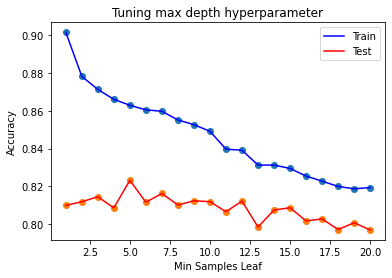

In [727]:
model = DecisionTreeClassifier(random_state=0)
cv = KFold(n_splits=3, shuffle=True, random_state=0)
params = {'max_depth':[i+1 for i in range(20)], \
          'min_samples_leaf': [i+1 for i in range(20)],\
         }
cv_model = GridSearchCV(model, param_grid=params, scoring='accuracy', refit=True, return_train_score=True, cv=cv)
cv_model.fit(X_train, y_train)
model = cv_model.best_estimator_
model.fit(X_train, y_train)
yhat_train = model.predict(X_train)
yhat_test = model.predict(X_test)

print('Best maximum depth: %i' % cv_model.best_params_['max_depth'])
print('Best min_samples_leaf: %i' % cv_model.best_params_['min_samples_leaf'])
chosen_hyperparams[0] = cv_model.best_params_


print('Accuracy (train): %.2f' % accuracy_score(y_train, yhat_train))
print('Accuracy (test): %.2f' % accuracy_score(y_test, yhat_test))

print('Precision (train): %.2f' % recall_score(y_train, yhat_train))
print('Precision (test): %.2f' % recall_score(y_test, yhat_test))

print('Recall (train): %.2f' % precision_score(y_train, yhat_train))
print('Recall (test): %.2f' % precision_score(y_test, yhat_test))

model_results = pd.DataFrame(cv_model.cv_results_)
mean_train = model_results.groupby('param_min_samples_leaf')['mean_train_score'].mean()
mean_test = model_results.groupby('param_min_samples_leaf')['mean_test_score'].mean()
x = [i+1 for i in range(20)]
plt.scatter(x, mean_train)
plt.plot(x, mean_train, c='b', label='Train')
plt.scatter(x, mean_test)
plt.plot(x, mean_test, c='r', label='Test')
plt.xlabel("Min Samples Leaf")
plt.ylabel("Accuracy")
plt.title("Tuning max depth hyperparameter")
plt.legend()
plt.show();

In [728]:
model_results = pd.DataFrame(cv_model.cv_results_)
mean_train_max_depth = model_results.groupby('param_max_depth')['mean_train_score'].mean()
mean_train_min_samples_leaf = model_results.groupby('param_min_samples_leaf')['mean_train_score'].mean()
z = np.zeros([19,19])
for i in np.arange(1,20):
    for j in np.arange(1,20):
        z[i-1,j-1] = model_results[(model_results['param_max_depth']==i) & (model_results['param_min_samples_leaf']==j)]['mean_test_score']

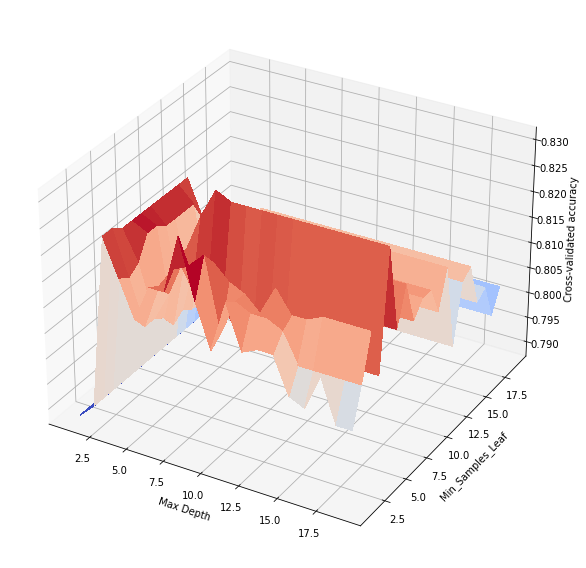

In [729]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121, projection='3d')
_x = np.arange(1,20)
_y = np.arange(1,20)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()
ax.plot_surface(_yy, _xx, z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel("Max Depth")
ax.set_ylabel("Min_Samples_Leaf")
ax.set_zlabel("Cross-validated accuracy")
plt.tight_layout()
plt.show();

*The combination of parameters that achieves the highest accuracy is max_depth=8 and min_samples_leaf=5. The accuracy seems to be very sensitive to changes in min_samples_leaf. However, for the optimal level of min_samples_leaf, accuracy doesn't seem very responsive to max depth. For other values of min_samples_leaf, accuracy is rather sensitive to max_depth as well, however.*

Score on holdout test data: 0.8268156424581006


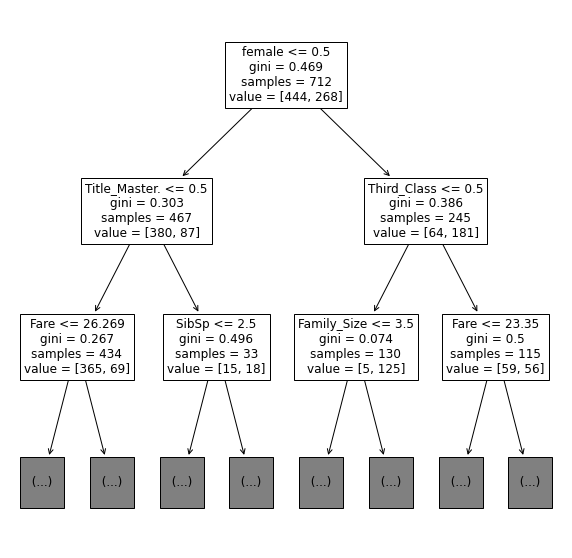

In [730]:
clf = DecisionTreeClassifier(max_depth=cv_model.best_params_['max_depth'], min_samples_leaf=cv_model.best_params_['min_samples_leaf'], random_state=0)
X = df.loc[:,features]
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf.fit(X_train, y_train)
average_cross_val_score = cross_val_score(clf, X_train, y_train, cv=10).sum() / 10
cross_val_perf[0] = average_cross_val_score
train_perf[0] = clf.score(X_train, y_train)
test_perf[0] = clf.score(X_test, y_test)
print("Score on holdout test data: {}".format(clf.score(X_test, y_test)))
plt.figure(figsize=(10,10))
tree.plot_tree(clf, max_depth=2, fontsize=12, feature_names=X.columns)
plt.show();

*The tree looks somewhat similar to above, but with different values for each split. Furthermore, the right side is slightly different, with Fare being a more determinative split for the women than Log_Fare as above.*

### 2.4 Missing Data, Imputation and Feature Engineering

Have you been paying close attention to your features? If not, now is a good time to start. Perform analysis that allows you to answer the following questions:
* Recall from part 1 that some features have missing data. Which features have missingness?
* Try running the decision tree using all columns, including those with missing data. What happens?
* Use one of the methods we discussed in class to impute missing values for each feature. For each feature with missingness, describe the method used and why it is appropriate to the feature.
* Find a way to engineer meaningful features from the "Name" and/or "Cabin" fields in the data.
* Rerun your decision tree and SVM on the new dataset with imputed missing values and the new features, including re-selecting hyperparameters via cross validation. What do you notice?

*The features that have missing data are: Age, Cabin and Embarked.*

In [731]:
# Your code here
# Running decision tree with all data, including those with missingness

# clf = DecisionTreeClassifier(max_depth=4, min_samples_leaf=1, random_state=0)
# X = df.loc[:,df.keys()!='Survived']
# y = df['Survived']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# clf.fit(X_train, y_train)
# print("Score on holdout test data: {}".format(clf.score(X_test, y_test)))
# plt.figure(figsize=(25,25))
# tree.plot_tree(clf, max_depth=4, fontsize=12, feature_names=X.columns)
# plt.show();

*Adding in the features with missing values raises an error. I've commented this out for submission to ensure my entire notebook runs.*

In [732]:
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

# Imputing Age values using the mean value
imp = SimpleImputer(missing_values=np.NaN, strategy='mean')
X = full_df['Age']
imputed_age = imp.fit_transform(X.values.reshape(-1,1))[:,0]
imputed_age = pd.DataFrame(imputed_age, columns=['Age'])
full_df['Age'] = imputed_age

*I imputed age using the mean value because that's our best guess of what the actual value of these people's ages would be (i.e. the random sample of actual values we've gotten is our best estimate of the population).*

In [733]:
# Imputing Cabin values - splitting into cabin imputation and number imputation
full_df['Cabin'].to_frame()
Z = full_df['Cabin']

# Pattern for finding the room number
num = Z.str.split(pat='[a-zA-Z]').str[1]

# Pattern for finding cabin letter
let = Z.str.split(pat='[0-9]').str[0]
a = pd.DataFrame(let)
b = pd.DataFrame(num)

# Concatenating the two series into a new dataframe
new_df = pd.concat([a,b], axis=1)
new_df.columns = ['Letter', 'Number']
new_df

# Imputing letter values using nearest neighbor
imputer = KNNImputer(missing_values=10, n_neighbors=5)
le = LabelEncoder()
le.fit_transform(new_df['Letter']).reshape(-1,1)
imputed_cabin = le.inverse_transform(imputer.fit_transform(le.fit_transform(new_df['Letter']).reshape(-1,1)).astype(int).ravel())
imputed_cabin

# Imputing cabin numbers using nearest neighbor
imputer = KNNImputer(missing_values=np.NaN, n_neighbors=5)
new_df['Number'].to_frame()
imputed_number = imputer.fit_transform(new_df['Number'].to_frame().fillna('-1').replace(" ", "-1").replace("", "-1").astype(int).replace(-1,np.nan))
imputed_number = imputed_number.astype(int).astype(str)

# Concatenating the cabin and the room number
imputed_cabin_number = imputed_cabin + imputed_number.ravel()
imputed_cabin_number = pd.DataFrame(imputed_cabin_number, columns=['Cabin'])
full_df['Cabin'] = imputed_cabin_number
full_df['Cabin_Letter'] = imputed_cabin

*For Cabin, I split the imputation into two parts - what cabin/class and the room number. For cabin, I used k-nearest neighbors classification, with k=5. I used this method because the cabin is categorical information, rather than numerical. For room number, I also used k-nearest neighbors. However, it seems to just guess the mean room number for all cabins (and I don't use this information to create any new variables). I then concatenated the arrays index-wise for a fully imputed cabin variable.*

In [734]:
# Imputing missing data
imp = SimpleImputer(missing_values=np.NaN, strategy='most_frequent')
imputed_embarked = pd.DataFrame(imp.fit_transform(full_df['Embarked'].values.reshape(-1,1))[:,0], columns=['Embarked'])
full_df['Embarked'] = imputed_embarked

*For embarked (which only had two nan values), I used the most frequent embarkation port, because that's where most people got on. Alternatively, you could have looked to see if embarkation port was incredibly correlated with cabin/class. However, I thought that since there were only two missing values, the most frequent would be a simpler and more straightforward approach.*

*In the feature engineering step above, I created dummy variables for a child (age<18) and dummy variables based on one's title. My initial trees found the Master title highly predictive for the men. I re-ran this preprocessing step using the imputted data. I also added new dummies for one's cabin (e.g. cabin A, cabin B).*

In [735]:
# Re-running with tree classifier using imputed data
full_df['Child'] = (full_df['Age'] < 18.0).astype(int)
full_df = full_df.drop(columns=['Cherbourg', 'Queenstown', 'Southampton'])
ports = pd.get_dummies(full_df['Embarked'])
ports.columns = ['Cherbourg', 'Queenstown', 'Southampton']
full_df = pd.concat([full_df, ports], axis=1)

# # Adding in cabin dummies
cabins = pd.get_dummies(full_df['Cabin_Letter'])
cabins.columns = ['Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', \
                  'Cabin_F', 'Cabin_FE', 'Cabin_FG', 'Cabin_G', 'Cabin_T']
full_df = pd.concat([full_df, cabins], axis=1)
full_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_FE,Cabin_FG,Cabin_G,Cabin_T
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,...,0,0,1,0,0,0,0,0,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.000000,1,0,PC 17599,71.2833,...,0,0,1,0,0,0,0,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,...,0,0,1,0,0,0,0,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,...,0,0,1,0,0,0,0,0,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,...,0,0,1,0,0,0,0,0,0,0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,...,0,1,0,0,0,0,0,0,0,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,29.699118,1,2,W./C. 6607,23.4500,...,0,0,1,0,0,0,0,0,0,0
889,890,1,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,30.0000,...,0,0,1,0,0,0,0,0,0,0


In [736]:
full_df = full_df.drop(['Name','Cabin', 'Cabin_Letter','Pclass', 'Sex', 'Ticket', 'Embarked'], axis=1)

*I then re-run my cross-validation step, and find new optimal hyperparameters.*

In [737]:
features = ['Age', 'SibSp', 'Parch', 'Fare',
       'First_Class', 'Second_Class', 'Third_Class', 'Title_Mr.', 'Title_Mrs.',
       'Title_Miss.', 'Title_Master.', 'Title_Dr.', 'Title_Rev.', 'female',
       'Child', 'Family_Travel', 'Family_Size', 'Traveling Alone',
       'Log_Fare', 'Cherbourg', 'Queenstown', 'Southampton',
       'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F',
       'Cabin_FE', 'Cabin_FG', 'Cabin_G', 'Cabin_T']

X = full_df.loc[:,features]
y = full_df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeClassifier(random_state=0)
cv = KFold(n_splits=3, shuffle=True, random_state=0)
params = {'max_depth':[i+1 for i in range(20)], \
          'min_samples_leaf': [i+1 for i in range(20)],\
         }
cv_model = GridSearchCV(model, param_grid=params, scoring='accuracy', refit=True, return_train_score=True, cv=cv)
cv_model.fit(X_train, y_train)
model = cv_model.best_estimator_
model.fit(X_train, y_train)
yhat_train = model.predict(X_train)
yhat_test = model.predict(X_test)

print('Best maximum depth: %i' % cv_model.best_params_['max_depth'])
print('Best min_samples_leaf: %i' % cv_model.best_params_['min_samples_leaf'])
chosen_hyperparams[1] = cv_model.best_params_

print('Accuracy (train): %.2f' % accuracy_score(y_train, yhat_train))
print('Accuracy (test): %.2f' % accuracy_score(y_test, yhat_test))

print('Precision (train): %.2f' % recall_score(y_train, yhat_train))
print('Precision (test): %.2f' % recall_score(y_test, yhat_test))

print('Recall (train): %.2f' % precision_score(y_train, yhat_train))
print('Recall (test): %.2f' % precision_score(y_test, yhat_test))

Best maximum depth: 6
Best min_samples_leaf: 15
Accuracy (train): 0.84
Accuracy (test): 0.80
Precision (train): 0.75
Precision (test): 0.74
Recall (train): 0.81
Recall (test): 0.76


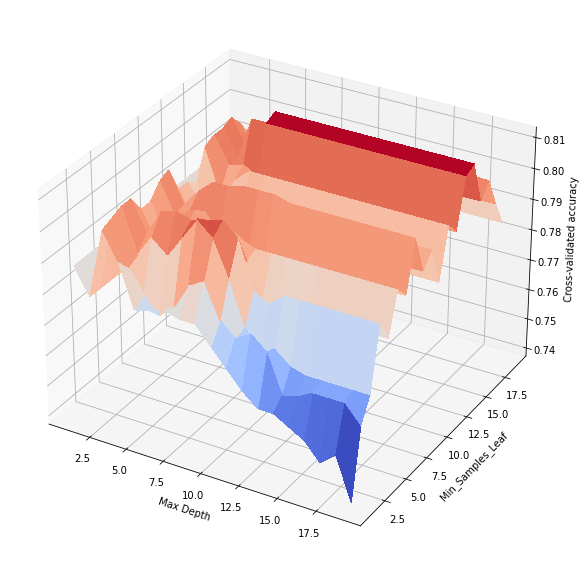

In [738]:
model_results = pd.DataFrame(cv_model.cv_results_)
mean_train_max_depth = model_results.groupby('param_max_depth')['mean_train_score'].mean()
mean_train_min_samples_leaf = model_results.groupby('param_min_samples_leaf')['mean_train_score'].mean()
z = np.zeros([19,19])
for i in np.arange(1,20):
    for j in np.arange(1,20):
        z[i-1,j-1] = model_results[(model_results['param_max_depth']==i) & (model_results['param_min_samples_leaf']==j)]['mean_test_score']
        
        
# %matplotlib inline
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121, projection='3d')
_x = np.arange(1,20)
_y = np.arange(1,20)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()
ax.plot_surface(_yy, _xx, z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel("Max Depth")
ax.set_ylabel("Min_Samples_Leaf")
ax.set_zlabel("Cross-validated accuracy")
plt.tight_layout()
plt.show();

Score on holdout test data: 0.7988826815642458


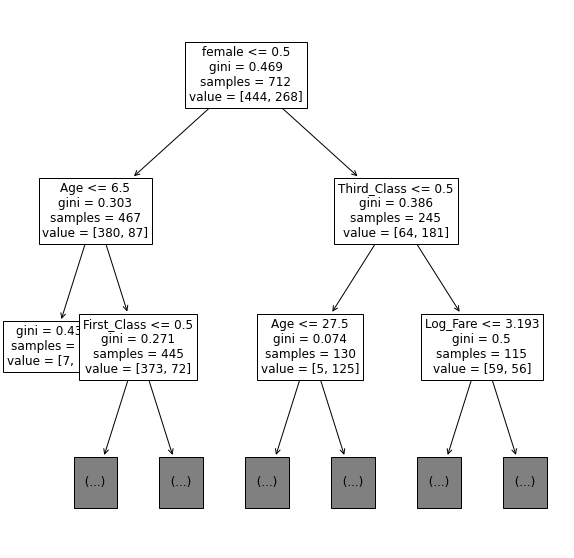

In [739]:
# Running new tree with imputed data and tuned hyperparameters
clf = DecisionTreeClassifier(max_depth=cv_model.best_params_['max_depth'], min_samples_leaf=cv_model.best_params_['min_samples_leaf'], random_state=0)
X = full_df.loc[:,features]
y = full_df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf.fit(X_train, y_train)
average_cross_val_score = cross_val_score(clf, X_train, y_train, cv=10).sum() / 10
cross_val_perf[1] = average_cross_val_score
train_perf[1] = clf.score(X_train, y_train)
test_perf[1] = clf.score(X_test, y_test)
print("Score on holdout test data: {}".format(clf.score(X_test, y_test)))
plt.figure(figsize=(10,10))
tree.plot_tree(clf, max_depth=2, fontsize=12, feature_names=X.columns)
plt.show();

*Then, I re-run the decision tree using those optimal hyperparameters. The test accuracy seems to have gone down - to ~.798. I attribute this to potential omitted variable bias in excluding data with missing values.*

*Interestingly, I find a very similar tree to above, but with a different order of splits. For instance, it weighs the age of males very heavily (e.g. if you were a male child, you were more likely to survive), and on the female side, it focuses on age and log_fare rather than family size and fare.*

### 2.5 ROC Curve

For your best decision tree from 2.4, plot the reciever operating characteristic (ROC) curve on the test set data. Report the area under the curve (AUC) score. *Hint*: scikit-learn's built-in predict_proba function may be helpful for this problem.  For each model, identify the point on the ROC curve that is closest to the top-left corner, and identify the associated probability threshold for classification. Place a vertical line on your plot indicating the FPR value at the threshold. Finally, report accuracy on the test set using the threshold you identified. Comparing to the accuracy from 2.4, what do you observe? 

AUC score: 0.87
Threshold closest to top-left corner of graph: 0.33 (0.81 TPR, 0.23 FPR)
Accuracy with new cut-off: 0.79


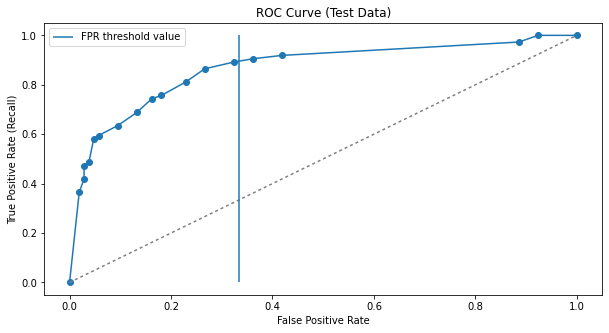

In [740]:
# Your code here
yhat_test_proba = clf.predict_proba(X_test)[:, 1]
fprs, tprs, thresholds = roc_curve(y_test, yhat_test_proba)

print('AUC score: %.2f' % roc_auc_score(y_test, yhat_test_proba))

distances_from_top_left = [np.sqrt(fprs[i]**2 + (1-tprs[i])**2) for i in range(len(tprs))]
best_cutoff = np.argmin(distances_from_top_left)
print('Threshold closest to top-left corner of graph: %.2f (%.2f TPR, %.2f FPR)' % 
      (thresholds[best_cutoff], tprs[best_cutoff], fprs[best_cutoff]))

y_pred = (clf.predict_proba(X_test)[:,1] >= thresholds[best_cutoff]).astype('float')
print('Accuracy with new cut-off: %.2f' % accuracy_score(y_test, y_pred))

fig, ax = plt.subplots(1, figsize=(10, 5))
ax.scatter(fprs, tprs)
ax.plot(fprs, tprs)
ax.plot([0, 1], [0, 1], color='grey', dashes=[2, 2])
ax.vlines(thresholds[best_cutoff], 0,1, label='FPR threshold value')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate (Recall)')
ax.set_title('ROC Curve (Test Data)')
plt.legend()
plt.show();

*Using the calculated optimal threshold based on the ROC curve results in a slightly lower accuracy of ~0.79. With this new threshold value we are accepting more false positives (e.g. classifying some who died on the Titanic as having survived) to reduce the number of false negatives (e.g. falsely classifying those who survived as having died). If we were really concerned about false negatives, it might make sense to adopt this thresholding approach compared to the default 50/50 split.*

## Part 3: Many Trees

### 3.1: Random Forest
Use the [random forest classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) to predict survival on the titanic. Use cross-validation on the training data to choose the best hyper-parameters --- including the maximum depth, number of trees in the forest, and the minimum samples per leaf.
* What hyperparameters did you select with cross-validation? You should use cross-validation to select all of the hyperparameters (i.e. search a grid of hyperparameters), and report the combination that maximizes cross-validated accuracy). You can use fewer cross validation folds than the 10 folds from previous problems, to keep your code from taking too long to run. _Hint:_ sklearn's [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) might be useful for this part
* How does the cross-validated performance (average across validation folds) compare to the test performance (using the top-performing, fitted model selected through cross-validation)?
* How does the RF performance compare to the decision tree from part 2.4?
* Create 3 subplots that show how cross-validated performance (y-axis) relates to the number of trees in the forest (x-axis), maximum depth (x-axis), and minimum samples per leaf (x-axis). What do you observe?

In [741]:
# Your code here
model = RandomForestClassifier(random_state=0)
cv = KFold(n_splits=3, shuffle=True, random_state=0)
params = {'max_depth':[2,4,6,8,10], \
          'n_estimators':[25, 50, 100, 200], \
          'min_samples_leaf': [2,4,6,8,10]}
cv_model = GridSearchCV(model, param_grid=params, scoring='accuracy', refit=True, return_train_score=True, cv=cv)
cv_model.fit(X_train, y_train)
model = cv_model.best_estimator_
model.fit(X_train, y_train)
yhat_train = model.predict(X_train)
yhat_test = model.predict(X_test)

print('Best maximum depth: %i' % cv_model.best_params_['max_depth'])
print('Best min_samples_leaf: %i' % cv_model.best_params_['min_samples_leaf'])
print('Best number of estimators: %i' % cv_model.best_params_['n_estimators'])


print('Accuracy (train): %.2f' % accuracy_score(y_train, yhat_train))
print('Accuracy (test): %.2f' % accuracy_score(y_test, yhat_test))

print('Precision (train): %.2f' % recall_score(y_train, yhat_train))
print('Precision (test): %.2f' % recall_score(y_test, yhat_test))

print('Recall (train): %.2f' % precision_score(y_train, yhat_train))
print('Recall (test): %.2f' % precision_score(y_test, yhat_test))

cross_val_perf[3] = np.mean(cv_model.cv_results_['mean_test_score'])
train_perf[3] = accuracy_score(y_train, yhat_train)
test_perf[3] = accuracy_score(y_test, yhat_test)
chosen_hyperparams[3] = cv_model.best_params_

Best maximum depth: 8
Best min_samples_leaf: 2
Best number of estimators: 200
Accuracy (train): 0.89
Accuracy (test): 0.82
Precision (train): 0.77
Precision (test): 0.74
Recall (train): 0.93
Recall (test): 0.81


In [742]:
np.mean(cv_model.cv_results_['mean_test_score'])
print('The cross validated test score is: ~{}, compared to the top-perfoming fitted model test score: ~{}'\
      .format(np.round(np.mean(cv_model.cv_results_['mean_test_score']),4), \
              np.round(accuracy_score(y_test, yhat_test),4)))

The cross validated test score is: ~0.8186, compared to the top-perfoming fitted model test score: ~0.8212


*The random forest model improves upon the decision tree model from 2.4: ~0.8212 vs ~0.798.*

Text(0.5, 0.98, 'Cross-validated performance by hyperparameter values')

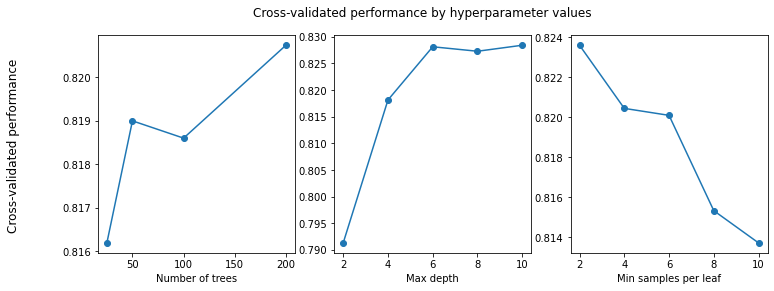

In [743]:
fig, ax = plt.subplots(1,3, figsize=(12,4))
fig.supylabel("Cross-validated performance")

# To calcualte average perforamnce for max_depth, divide into 5 segments of 20
# To calcualte for min_samples_leaf, look at first 4 every 20
# To calculate for number of estimators, look at every 5th

# Plotting number of trees
ax[0].set_xlabel("Number of trees")
length = len(cv_model.cv_results_['mean_test_score'])
ax[0].scatter([25, 50, 100, 200], [np.mean(cv_model.cv_results_['mean_test_score'][i:length-4+i+1:4]) for i in range(4)])
ax[0].plot([25, 50, 100, 200], [np.mean(cv_model.cv_results_['mean_test_score'][i:length-4+i+1:4]) for i in range(4)])

# Plotting max depth
ax[1].set_xlabel("Max depth")
ax[1].scatter([2,4,6,8,10],[array.mean() for array in np.array_split(cv_model.cv_results_['mean_test_score'],5)])
ax[1].plot([2,4,6,8,10],[array.mean() for array in np.array_split(cv_model.cv_results_['mean_test_score'],5)])

# Plotting min samples per leaf
# Grouping values into four groupings every 20 values, and then calcualting average performance
leaf_array = [[-100] for i in range(5)]
for i in range(length):
    if leaf_array[int((i)/4)%(5)] == [-100]:
        leaf_array[int((i)/4)%(5)] = [cv_model.cv_results_['mean_test_score'][i]]
    else:
        leaf_array[int((i)/4)%(5)].append(cv_model.cv_results_['mean_test_score'][i])
        
leaf_values = [np.mean(leaf_array[i]) for i in range(len(leaf_array))]
ax[2].scatter([2,4,6,8,10], leaf_values)
ax[2].plot([2,4,6,8,10], leaf_values)
ax[2].set_xlabel("Min samples per leaf")
fig.suptitle("Cross-validated performance by hyperparameter values")

*Accuracy seems to improve as we add number of trees and max depth, but decrease as we increase the min samples per leaf. These results all make sense, because random forests (and decision trees in general) are prone to overfitting, which would happen best when we have a large number of trees at a large depth with as few samples per leaf as possible.*

### 3.2: Gradient Boosting

Use the [Gradient Boosting classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) to predict survival on the Titanic. Tune your hyperparameters with cross validation. Again, you should tune more parameteres than just `max_depth`.
* How does the GBM performance compare to the other models?
* Create a figure showing the feature importances in your final model (with properly tuned hyperparameters)


In [744]:
# Your code here
model = GradientBoostingClassifier(random_state=0)
cv = KFold(n_splits=3, shuffle=True, random_state=0)
params = {'max_depth':[2,4,6,8,10], \
          'n_estimators':[25, 50, 100, 200], \
          'min_samples_leaf': [2,4,6,8,10]}
cv_model = GridSearchCV(model, param_grid=params, scoring='accuracy', refit=True, return_train_score=True, cv=cv)
cv_model.fit(X_train, y_train)
model = cv_model.best_estimator_
model.fit(X_train, y_train)
yhat_train = model.predict(X_train)
yhat_test = model.predict(X_test)

print('Best maximum depth: %i' % cv_model.best_params_['max_depth'])
print('Best min_samples_leaf: %i' % cv_model.best_params_['min_samples_leaf'])
print('Best number of estimators: %i' % cv_model.best_params_['n_estimators'])


print('Accuracy (train): %.2f' % accuracy_score(y_train, yhat_train))
print('Accuracy (test): %.2f' % accuracy_score(y_test, yhat_test))

print('Precision (train): %.2f' % recall_score(y_train, yhat_train))
print('Precision (test): %.2f' % recall_score(y_test, yhat_test))

print('Recall (train): %.2f' % precision_score(y_train, yhat_train))
print('Recall (test): %.2f' % precision_score(y_test, yhat_test))

cross_val_perf[5] = np.mean(cv_model.cv_results_['mean_test_score'])
train_perf[5] = accuracy_score(y_train, yhat_train)
test_perf[5] = accuracy_score(y_test, yhat_test)
chosen_hyperparams[5] = cv_model.best_params_

Best maximum depth: 2
Best min_samples_leaf: 10
Best number of estimators: 200
Accuracy (train): 0.89
Accuracy (test): 0.82
Precision (train): 0.78
Precision (test): 0.76
Recall (train): 0.92
Recall (test): 0.80


In [745]:
model.feature_importances_

array([8.89538426e-02, 1.13713171e-02, 2.55419909e-03, 5.41303110e-02,
       6.07276121e-04, 0.00000000e+00, 1.28150398e-01, 6.74253469e-02,
       1.49644956e-02, 5.46307515e-04, 2.00023805e-02, 0.00000000e+00,
       0.00000000e+00, 4.22170475e-01, 0.00000000e+00, 0.00000000e+00,
       8.12458735e-02, 0.00000000e+00, 4.80031431e-02, 4.27572875e-03,
       3.24916450e-04, 9.18448586e-03, 0.00000000e+00, 1.45821342e-03,
       3.53126560e-02, 8.31432003e-04, 8.48720148e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

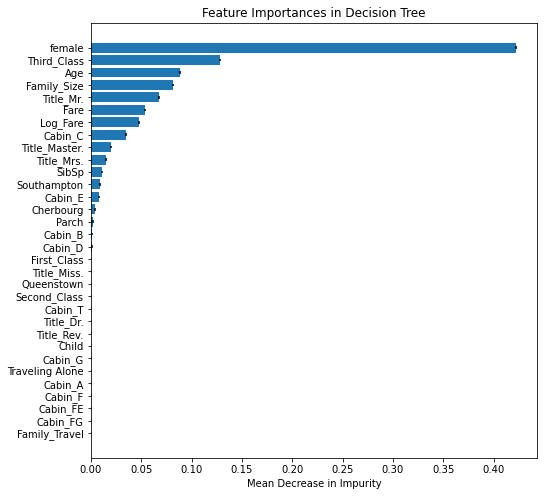

In [746]:
model.feature_importances_
importances = pd.DataFrame([features, model.feature_importances_]).T
importances.columns = ['Feature', 'Importance']
importances = importances.sort_values('Importance', ascending=True)
importances
std = np.std(clf.feature_importances_)
fig, ax = plt.subplots(1, figsize=(8,8))
plt.barh(importances['Feature'], importances['Importance'], yerr=std)
ax.set_xlabel('Mean Decrease in Impurity')
ax.set_title('Feature Importances in Decision Tree')
plt.show()

*The Gradient Boosting model performs similarly to the Random Forest model (accuracy of ~0.82). The feature importances are fairly different from those from question 2, however. Female and third class are still the highest importance, but SibSp, LogFare, and Title_Master fall in importance in this model, while Age, Family Size and Title_Mr. rise in importance. This makes more sense to me, as younger people and those with smaller families seem like they should have been more likely to survive.*

## Part 4: Neural Networks

Carry on the classification by using feed forward neural networks, using functionality imported from [keras](https://keras.io/api/). You are responsible for choosing the number of layers, their corresponding size, the activation functions and the choice of gradient descent algorithm (and its parameters e.g. learning rate). Pick those parameters by hand. For some of them you can also perform cross-validation if you wish, but cross validation is not required. Your goal is to tune those parameters so that your test accuracy is at least above 75%. 

Report your accuracy on the test set along with your choice of parameters. More specifically, report the number of layers, their size, the activation functions and your choice of optimization algorithm. 

It is a good exercise to experiment with different optimizers (gradient descent, stochastic gradient descent, AdaGrad etc), learning rates, batch sizes etc. to get a feeling of how they affect neural network training. Experiment with some of these options. What do you observe?

In [747]:
# Your code here
from keras.models import Sequential
from keras.layers import Dense

In [748]:
model = Sequential()
model.add(Dense(20, input_dim=len(X_train.columns), activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

# Fit and predict with NN
model.fit(X_train, y_train, epochs=50, batch_size=10, verbose=0)
yhat_train = (model.predict(X_train) > 0.5).astype(int)
yhat_test = (model.predict(X_test) > 0.5).astype(int)

# Get metrics
print('Accuracy on training set: %.2f' % accuracy_score(y_train, yhat_train))
print('Accuracy on test set: %.2f' % accuracy_score(y_test, yhat_test))

# cross_val_perf[7] = 'N/A'
# NOTE: I'm having the cross-validated performance stay 0.0, but it is N/A
train_perf[7] = accuracy_score(y_train, yhat_train)
test_perf[7] = accuracy_score(y_test, yhat_test)
chosen_hyperparams[7] = {'Layer': 1, 'Nodes': 20, 'Activation': 'Relu', 'Optimizer': 'Adam'}

6/6 [==============================] - 0s 3ms/step
Accuracy on training set: 0.85
Accuracy on test set: 0.80


*The accuracy of the Neural Network fluctuates a bit each time I run it, but train accuracy is usually around 0.85, and test accuracy is generally around ~0.79-0.82.*

*Chosen Parameters:*
 * Number of layers: I tried adding a number of extra hidden layers (I tried 1-4), and it didn't seem to have any impact. In fact, I found having 4 layers reduced the accuracy.
 * Layer size: I experimented with number of nodes quite a bit, trying between 5 and 100 in steps of 5-10 or so. I found the highest train and test accuracy was with 20 nodes.
 * Activation function: I used relu as we discussed in class. I did experiment with some of the others and it drastically reduced overall accuracy.
 * Optimization algorithm: I tried a number of keras' optimizers (Adagrad, Ftrl, RMSprop, Adam) and found that Adam was by far the best. RMSprop was the closest to Adam, but the first two had accuracy scores in the 60% range.

## Part 5: Putting it all together!

Create a final table that summarizes the performance of your models as follows. What do you observe? Are there trends in which models and hyperparameters work best?

| Model | Cross-validated Performance   | Train Performance | Test Performance | Chosen Hyperparameters | 
|------|------|------| | |
|   Decision Tree        |  |  |  |  |
|   Decision Tree (with imputed missing values and new features) |  |  |  |  |
|   Random Forest        |  |  |  |  |
|   Random Forest (with imputed missing values and new features)        |  |   |  | |
|   Gradient Boosting    |  |  |  |  |
|   Gradient Boosting (with imputed missing values and new features)        |  |  |  |  |
|   Neural Network    |  |  |  |  |
|   Neural Network (with imputed missing values and new features)        |  |   |  |  |

In [749]:
# Random forest with original data
model = RandomForestClassifier(random_state=0)
cv = KFold(n_splits=3, shuffle=True, random_state=0)
params = {'max_depth':[2,4,6,8,10], \
          'n_estimators':[25, 50, 100, 200], \
          'min_samples_leaf': [2,4,6,8,10]}
cv_model = GridSearchCV(model, param_grid=params, scoring='accuracy', refit=True, return_train_score=True, cv=cv)
cv_model.fit(X_train_original, y_train_original)
model = cv_model.best_estimator_
model.fit(X_train_original, y_train_original)
yhat_train = model.predict(X_train_original)
yhat_test = model.predict(X_test_original)

print('Best maximum depth: %i' % cv_model.best_params_['max_depth'])
print('Best min_samples_leaf: %i' % cv_model.best_params_['min_samples_leaf'])
print('Best number of estimators: %i' % cv_model.best_params_['n_estimators'])


print('Accuracy (train): %.2f' % accuracy_score(y_train_original, yhat_train))
print('Accuracy (test): %.2f' % accuracy_score(y_test_original, yhat_test))

print('Precision (train): %.2f' % recall_score(y_train_original, yhat_train))
print('Precision (test): %.2f' % recall_score(y_test_original, yhat_test))

print('Recall (train): %.2f' % precision_score(y_train_original, yhat_train))
print('Recall (test): %.2f' % precision_score(y_test_original, yhat_test))

cross_val_perf[2] = np.mean(cv_model.cv_results_['mean_test_score'])
train_perf[2] = accuracy_score(y_train_original, yhat_train)
test_perf[2] = accuracy_score(y_test_original, yhat_test)
chosen_hyperparams[2] = cv_model.best_params_

Best maximum depth: 6
Best min_samples_leaf: 4
Best number of estimators: 25
Accuracy (train): 0.86
Accuracy (test): 0.83
Precision (train): 0.73
Precision (test): 0.77
Recall (train): 0.87
Recall (test): 0.81


In [750]:
# Gradient boosting with original data
model = GradientBoostingClassifier(random_state=0)
cv = KFold(n_splits=3, shuffle=True, random_state=0)
params = {'max_depth':[2,4,6,8,10], \
          'n_estimators':[25, 50, 100, 200], \
          'min_samples_leaf': [2,4,6,8,10]}
cv_model = GridSearchCV(model, param_grid=params, scoring='accuracy', refit=True, return_train_score=True, cv=cv)

cv_model.fit(X_train_original, y_train_original)
model = cv_model.best_estimator_
model.fit(X_train_original, y_train_original)
yhat_train = model.predict(X_train_original)
yhat_test = model.predict(X_test_original)

print('Best maximum depth: %i' % cv_model.best_params_['max_depth'])
print('Best min_samples_leaf: %i' % cv_model.best_params_['min_samples_leaf'])
print('Best number of estimators: %i' % cv_model.best_params_['n_estimators'])


print('Accuracy (train): %.2f' % accuracy_score(y_train_original, yhat_train))
print('Accuracy (test): %.2f' % accuracy_score(y_test_original, yhat_test))

print('Precision (train): %.2f' % recall_score(y_train_original, yhat_train))
print('Precision (test): %.2f' % recall_score(y_test_original, yhat_test))

print('Recall (train): %.2f' % precision_score(y_train_original, yhat_train))
print('Recall (test): %.2f' % precision_score(y_test_original, yhat_test))

cross_val_perf[4] = np.mean(cv_model.cv_results_['mean_test_score'])
train_perf[4] = accuracy_score(y_train_original, yhat_train)
test_perf[4] = accuracy_score(y_test_original, yhat_test)
chosen_hyperparams[4] = cv_model.best_params_

Best maximum depth: 2
Best min_samples_leaf: 8
Best number of estimators: 200
Accuracy (train): 0.89
Accuracy (test): 0.82
Precision (train): 0.79
Precision (test): 0.78
Recall (train): 0.90
Recall (test): 0.78


In [751]:
# Neural network with original data
model = Sequential()
model.add(Dense(20, input_dim=len(X_train_original.columns), activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit and predict with NN
model.fit(X_train_original, y_train_original, epochs=50, batch_size=10, verbose=0)
yhat_train = (model.predict(X_train_original) > 0.5).astype(int)
yhat_test = (model.predict(X_test_original) > 0.5).astype(int)

# Get metrics
print('Accuracy on training set: %.2f' % accuracy_score(y_train_original, yhat_train))
print('Accuracy on test set: %.2f' % accuracy_score(y_test_original, yhat_test))

# cross_val_perf[6] = 'N/A'
# NOTE: I'm having the cross-validated performance stay 0.0, but it is N/A
train_perf[6] = accuracy_score(y_train_original, yhat_train)
test_perf[6] = accuracy_score(y_test_original, yhat_test)
chosen_hyperparams[6] = {'Layer': 1, 'Nodes': 20, 'Activation': 'Relu', 'Optimizer': 'Adam'}

6/6 [==============================] - 0s 862us/step
Accuracy on training set: 0.84
Accuracy on test set: 0.81


In [752]:
pd.set_option('display.max_colwidth', 0)
models = ['Decision Tree', \
          'Decision Tree (with imputed missing values and new features)', \
          'Random Forest', \
          'Random Forest (with imputed missing values and new features)', \
          'Gradient Boosting', \
          'Gradient Boosting (with imputed missing values and new features)', \
          'Neural Network', \
          'Neural Network (with imputed missing values and new features)']

cross_val_perf = np.round(cross_val_perf, 2)
train_perf = np.round(train_perf, 2)
test_perf = np.round(test_perf, 2)

results = {'Model': models, \
           'Cross-validated Performance': cross_val_perf, \
           'Train Performance': train_perf, \
           'Test Performance': test_perf, \
           'Chosen Hyperparameters': chosen_hyperparams,}
results_df = pd.DataFrame(results)
results_df

,Model,Cross-validated Performance,Train Performance,Test Performance,Chosen Hyperparameters
0,Decision Tree,0.83,0.88,0.83,"{'max_depth': 8, 'min_samples_leaf': 5}"
1,Decision Tree (with imputed missing values and new features),0.81,0.84,0.80,"{'max_depth': 6, 'min_samples_leaf': 15}"
2,Random Forest,0.82,0.86,0.83,"{'max_depth': 6, 'min_samples_leaf': 4, 'n_estimators': 25}"
3,Random Forest (with imputed missing values and new features),0.82,0.89,0.82,"{'max_depth': 8, 'min_samples_leaf': 2, 'n_estimators': 200}"
4,Gradient Boosting,0.82,0.89,0.82,"{'max_depth': 2, 'min_samples_leaf': 8, 'n_estimators': 200}"
5,Gradient Boosting (with imputed missing values and new features),0.81,0.89,0.82,"{'max_depth': 2, 'min_samples_leaf': 10, 'n_estimators': 200}"
6,Neural Network,0.00,0.84,0.81,"{'Layer': 1, 'Nodes': 20, 'Activation': 'Relu', 'Optimizer': 'Adam'}"
7,Neural Network (with imputed missing values and new features),0.00,0.85,0.80,"{'Layer': 1, 'Nodes': 20, 'Activation': 'Relu', 'Optimizer': 'Adam'}"


*The Decision Tree and Random Forest models work the best, which I did not expect. As the models get more and more complex, the accuract decreases (although they all are around 80%+. This likely means that there were relatively few factors that influenced survival or death on the Titanic - such as gender, age, and what class you were in. This likely means that the more complex models are overfitting the data (we see that the higehst train performances are with Gradient Boosting and Rnadom Forest with new features and imputed data).*

## Part 6: (Extra credit) Flex your ML chops

Add additional rows to the table from Part 5 based on other models you've learned in class or are aware of.
 - Which models perform the best, using the default parameters (i.e., no hyperparameter tuning)?
 - How do models perform in terms of performance metrics beyond accuracy? (e.g. AUC score, precision, recall) 
 - For which models does careful hyperparameter tuning make the biggest different? Why do you think that is the case?
 - Which tuned model has the largest gap between cross-validated performance and test performance? Why might that be?

Try atleast 2 different classes of models to receive full credit.

In [753]:
# Your code here

*Your observations here*